# Declustered statistics

In this tutorial, we demonstrate why it is important to take spatial coordinates of samples into account when computing statistics with a spatial dataset.

Before we proceed, please install the following packages:

In [1]:
] add GeoStats GeoStatsImages Plots

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [2]:
using Random; Random.seed!(1234); # make sure this tutorial is reproducible

## Gold mine example

We will pretend that we are a mining company interested in extracting a mineral such as Gold (Au). Based on the fact that we are trying to maximize profit, we end up collecting rock samples at nearby locations where we *believe* we will find the mineral we are after. Our data acquisition process therefore suffers from *sampling bias*, and because we are successfull in what we do, most of our samples reflect high concentrations of Gold.

We consider a synthetic Gold mine:

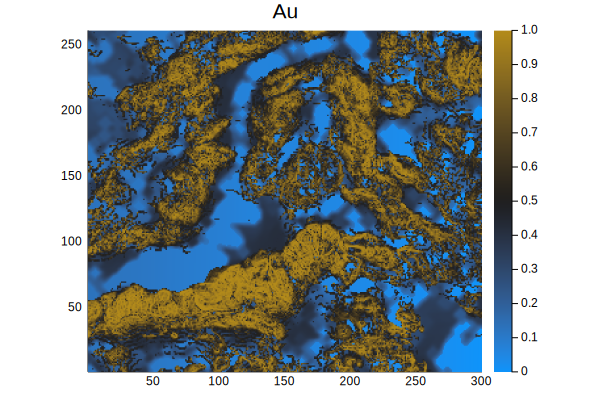

In [3]:
using GeoStats
using GeoStatsImages
using Plots

img = training_image("WalkerLakeTruth")[:,:,1]

mine = RegularGridData{Float64}(Dict(:Au => img))

mplot = heatmap(mine, c=:bky)

and dig samples at a few locations:

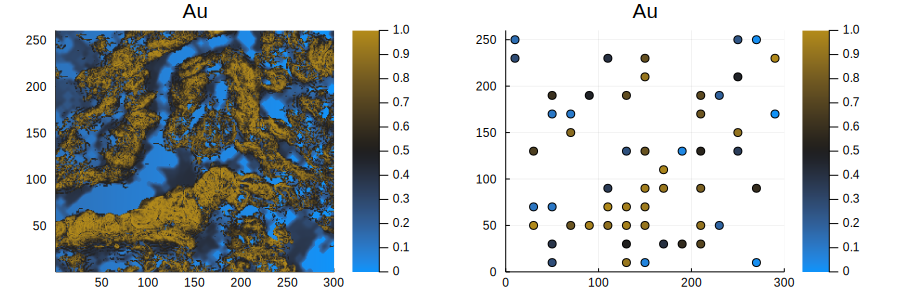

In [4]:
nx, ny = size(mine)

# extract data whenever Au > 0.9 or in 20% of other cases
xyval = []
for x in 10:20:nx, y in 10:20:ny
    obs = mine[x,y]
    [x,y]
    if obs.Au > 0.9 || rand() < 0.2
        push!(xyval, (x, y, obs.Au))
    end
end

# point set with samples
X = [v[1:2] for v in xyval]
z = [v[3] for v in xyval]
samples = PointSetData(Dict(:Au=>z), X)

splot = plot(samples, mc=:bky, ms=4,
             xlims=(0,nx), ylims=(0,ny), clim=(0,1))

plot(mplot, splot, size=(900,300))

The question we have is:

*Can we do any better to estimate the mean value of Gold in the mine, other than taking the average of available samples?*

$$\frac{1}{N}\sum_{i=1}^{N} Au(x_i)$$

We know that the available samples are not representative of the Gold distribution in the mine, and we also know that if we multiply this estimate of the mean by the area of the mine, we will overestimate how much Gold there is left to be extracted.

The mean value of Gold in the mine is

In [5]:
μm = mean(mine[:Au])

0.5

whereas the sample average is much higher:

In [6]:
μs = mean(samples[:Au])

0.5639250835599506

The answer to the above question is *Yes, we can do better*.

GeoStats.jl is able to provide an estimate of the mean that is closer to the true mean using only the samples:

In [7]:
μc = mean(samples, :Au)

0.4983989637991613

But how it does that?

In [8]:
println("Sample average error (%): ", 100(μs - μm) / μm)
println("GeoStats.jl error    (%): ", 100(μc - μm) / μm)

Sample average error (%): 12.785016711990128
GeoStats.jl error    (%): -0.32020724016773583


## Declustering

Notice that besides suffering from sampling bias, our data acquisition process leads to samples that are clustered in space. Samples that are close to each other are redundant, and shouldn't receive the same weight in the estimate of the mean:

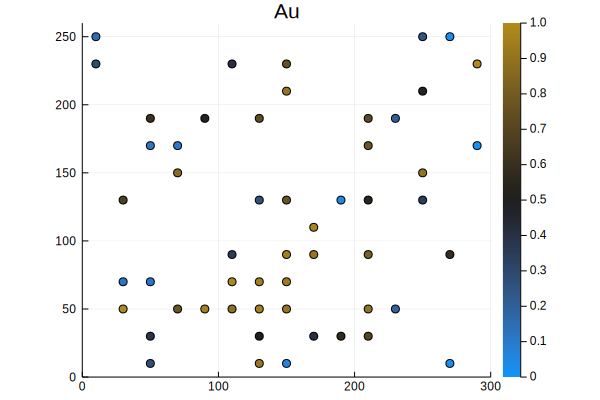

In [9]:
splot

To assign weights to samples, we **partition the point set** using a grid of blocks of given side, and **count the number of samples** inside each block. The more samples there are in a block, the lower are the weights. Equivalently, samples that are isolated receive more weight compared to samples that are clustered:

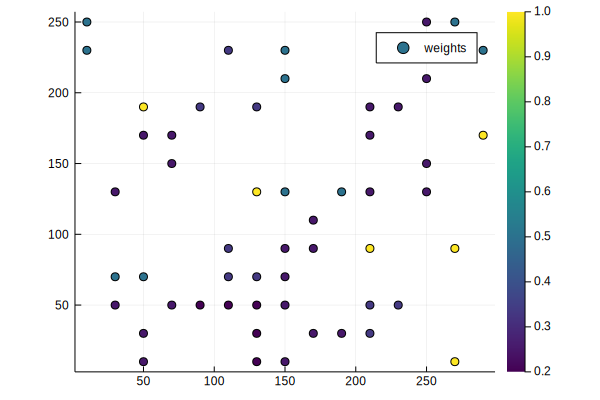

In [10]:
wd = weight(samples, BlockWeighter(60.))

plot(wd, ms=4, mc=:viridis)

A better estimate of the true mean in the mine is the weighted sample average:

$$\sum_{i=1}^N w_i(s) Au(x_i)$$

where the weights $w_i(s)$ are a function of the block side $s$:

In [11]:
mean(samples, :Au, 60.)

0.5064329274062731

In [12]:
mean(samples, :Au, 70.)

0.5187440570819284

We can plot estimates for different block sides:

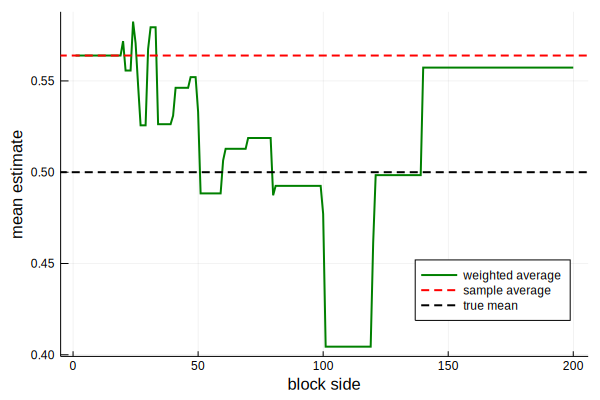

In [13]:
gr(lw=2)

blockside = 1:200
estimates = [mean(samples, :Au, s) for s in blockside]

plot(blockside, estimates,
    c=:green, xlabel="block side", ylabel="mean estimate",
    legend=:bottomright, label="weighted average")
hline!([μs], c=:red, ls=:dash, label="sample average")
hline!([μm], c=:black, ls=:dash, label="true mean")

to notice that the sample average (i.e. uniform weights) is recovered when the block side is too small (each sample is its own block), or when the block side is too large (all samples are in a single block). GeoStats.jl uses a heuristic to find a good tradeoff when the block side is not specified.

## Other statistics

The idea of "declustering" spatial data to weight samples is general, and holds for any statistic of interest. Hence, the term *declustered statistics*. For example, better estimates of any quantile of the Gold distribution are obtained by taking into account the spatial coordinates of the samples.

### Non-spatial quantile:

In [14]:
quantile(samples[:Au], [0.25,0.50,0.75])

3-element Array{Float64,1}:
 0.26315401479506145
 0.597289708842421  
 0.9026461877716381 

### Spatial quantile:

In [15]:
quantile(samples, :Au, [0.25,0.50,0.75])

3-element Array{Float64,1}:
 0.2599359942954092
 0.5889928991763632
 0.9016628418313055

## Conclusions

- GeoStats.jl is a truly spatial framework because it changes the semantics of operations such as `mean`, `var`, and `quantile` in a spatial context.
- Not only it hides the complexity of declustering spatial data from the user, it also generalizes these methods to wotk with any spatial configuration.